####  Here is demonstrarion of several pipelines to preproccess images, get embeddings from the model and build [AnnoyIndex](https://github.com/spotify/annoy) 

In [1]:
!nvidia-smi

NVIDIA-SMI has failed because you are not:
	a) running as an administrator or
	b) there is not at least one TCC device in the system



In [2]:
import sys
import os

import cv2 as cv
from imageio import imsave, imread, imwrite
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqn
%matplotlib inline

# sys.path.append('..')
from model import MyModel
from dataset import B,V,F, FilesIndex, Dataset, Pipeline, action, inbatch_parallel
from face_batch import CelebrityBatch, load_func

In [3]:
model_path = 'model/'
model_name = 'model-20170512-110547'
checkpoint_path = 'model-20170512-110547.ckpt-250000'
src_images = '../img_align_celeba/img_align_celeba/'
IMG_SHAPE = (160, 160)


#### Data preproccessing pipeline:
For face detection we use haaracasades from opencv

In [4]:
preprocess_ppl = (Pipeline()
     .load(src=src_images, fmt='image', components='images')
     .to_cv(src='images')
#      .to_rgb()
     .detect_face()
     .crop_from_bbox()
     .resize(IMG_SHAPE, fmt='cv')
     .to_rgb()
    )

#### To get embeddings we load pre-trained [facenet](https://github.com/davidsandberg/facenet) model

In [5]:
init_model_ppl = (Pipeline()
                    .init_model('static', MyModel, model_name,
                                config={'load' : {'path' : model_path, 'graph': model_name + '.meta',
                                                  'checkpoint' : checkpoint_path}, 
                                        'build': False}))

'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.
INFO:tensorflow:Restoring parameters from model/model-20170512-110547.ckpt-250000


In [6]:
predict_ppl = ((preprocess_ppl + init_model_ppl)
                .init_variable('predicted_embeddings', init_on_each_run=0)
                .init_variable('indices', init_on_each_run=0)
                .predict_model(model_name, fetches="embeddings:0",
                               feed_dict={'input:0' : B('images'), 'phase_train:0' : False},
                               save_to=B('embedding'), mode='w')
                .dump(dst='demo_embeddings.csv', fmt='csv', mode='a', components='embedding', header=False)
              )

To run pipeline we create instance of Dataset class which supports indexing over the data:

In [7]:
fileindex = FilesIndex(path=src_images+'*.jpg', no_ext=True)
dset = Dataset(fileindex, batch_class=CelebrityBatch)

And here we will run only several iterations: 

In [8]:
NUM_ITERS = 1
BATCH_SIZE = 5

In [9]:
for i in tqn(range(NUM_ITERS)):
    btch = (predict_ppl << dset).next_batch(BATCH_SIZE, n_epochs=1, shuffle=False, drop_last=True)

To create an Index we load saved embeddings and build Spotify's Annoy Index (for now)

In [252]:
fileindex = FilesIndex(path= '../img_align_celeba/cropped_photos/'+'*.jpg', no_ext=True)
dset = Dataset(fileindex, batch_class=CelebrityBatch)

In [253]:
build_index_ppl = (Pipeline()
                     .load(src='data/cropped_embeddings.csv', fmt='csv', components=['embedding'], dtype=str,
                           index_col='file_name', post=load_func)
                     .build_index('150k_index')
                     .dump(dst='int_indices_mapping.csv', fmt='csv', mode='a', components='int_indices', header=False)
                  ) << dset

In [18]:
tmp = build_index_ppl.next_batch(157220, n_epochs=1, shuffle=False, drop_last=True)

saved Index to path 150k_index


Now when we have built and saved Index to 150k_index.ann we can load use it to find nearest neighbours for new images:

In [42]:
# We use new photos from test dataset
# src_images = 'test_photos/'
src_images = 'me/' 
#open cv wants a path with slashes!

fileindex = FilesIndex(path= src_images+'*.jpg', no_ext=True)

test_set = Dataset(fileindex, batch_class=CelebrityBatch)

In [43]:
test_set.indices

array(['9'], dtype='<U8')

In [44]:
search_celebs_ppl = predict_ppl.find_nearest_neighbours(src='150k_index.ann', k_neighbours=15) << test_set

In [36]:
btch = search_celebs_ppl.next_batch(10, n_epochs=None)

haarcascade couldn't detect face on your photo ()


In [37]:
import pandas as pd
data = pd.read_csv('int_indices_mapping.csv', names=['file_name', 'int_index'], index_col='int_index')

original


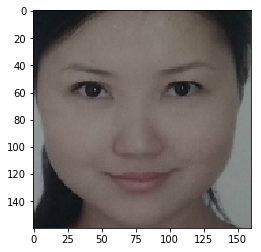

neighbour 47387
neighbour 15926
neighbour 174438
neighbour 50148
neighbour 198726
neighbour 193250
neighbour 178099


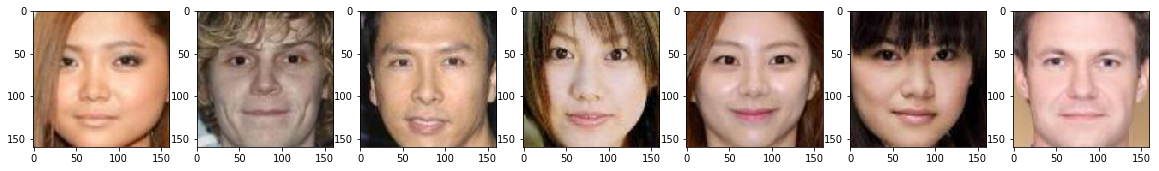

In [45]:
btch = search_celebs_ppl.next_batch(1, n_epochs=None)
for j in range(len(btch.indices)):
    print('original')
    pic = btch.images[j]
    plt.imshow(pic)
    plt.show()
    fig, ax = plt.subplots(nrows=1, ncols=7, figsize=(20, 120))
    for i, neighbour_index in enumerate(btch.neighbours[j][:7]):
        file_name = data.loc[neighbour_index, 'file_name']
        print('neighbour', file_name)
        pic = imread('../img_align_celeba/cropped_photos/' + str(file_name) + '.jpg')
        ax[i].imshow(pic)
    plt.show()

original


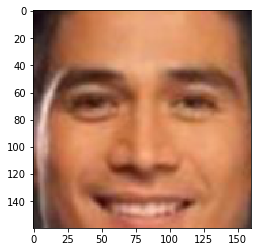

neighbour 35126
neighbour 10404
neighbour 148000
neighbour 158709
neighbour 141940
neighbour 189273
neighbour 53342


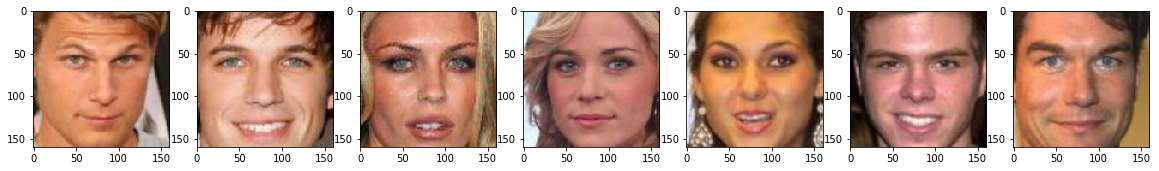

original


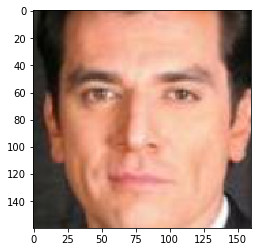

neighbour 55
neighbour 44840
neighbour 54675
neighbour 159012
neighbour 70295
neighbour 183132
neighbour 55612


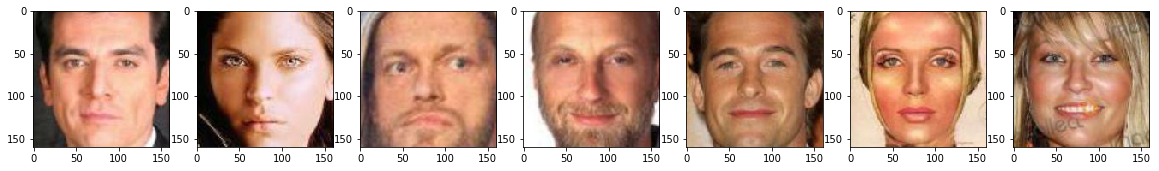

original


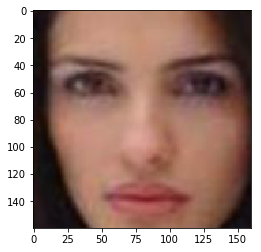

neighbour 132576
neighbour 111339
neighbour 38287
neighbour 124947
neighbour 116391
neighbour 35930
neighbour 190574


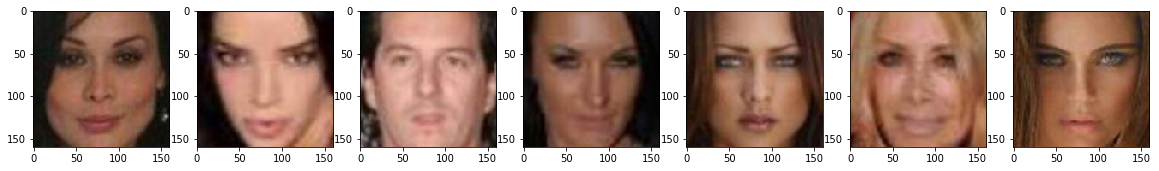

original


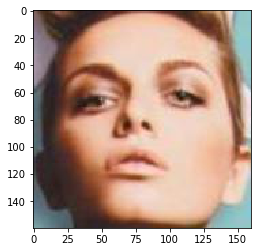

neighbour 5
neighbour 168273
neighbour 36442
neighbour 153763
neighbour 71572
neighbour 184255
neighbour 114213


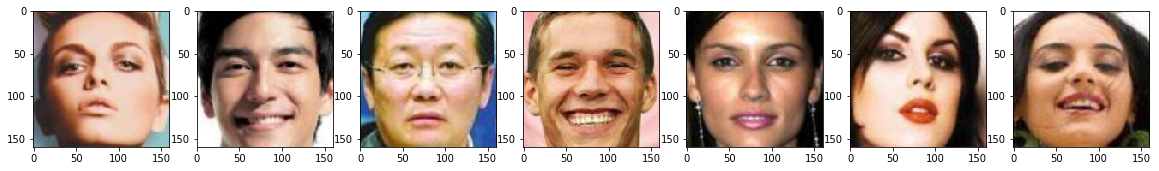

original


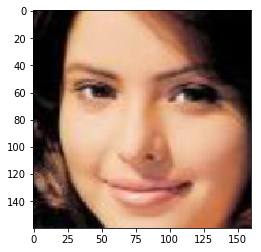

neighbour 43006
neighbour 193770
neighbour 190641
neighbour 190366
neighbour 66852
neighbour 183699
neighbour 54470


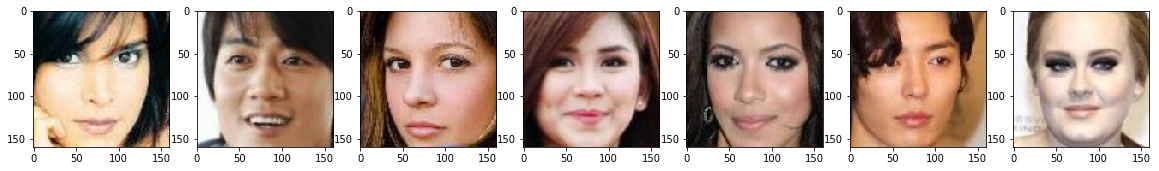

original


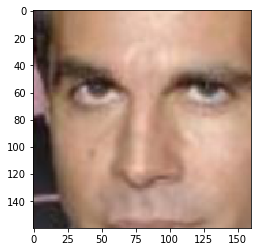

neighbour 114358
neighbour 6894
neighbour 149600
neighbour 199255
neighbour 107076
neighbour 160254
neighbour 47074


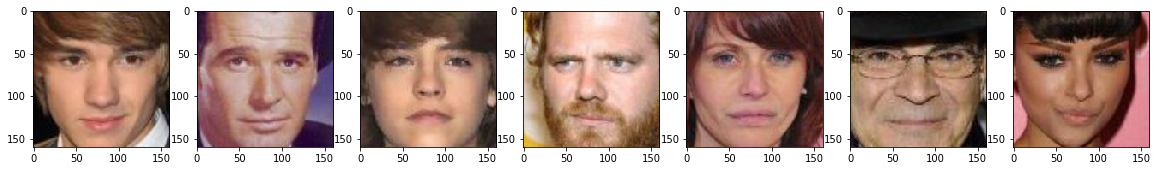

original


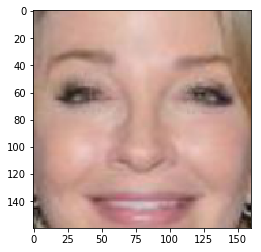

neighbour 176510
neighbour 55900
neighbour 127775
neighbour 160866
neighbour 15870
neighbour 28686
neighbour 151469


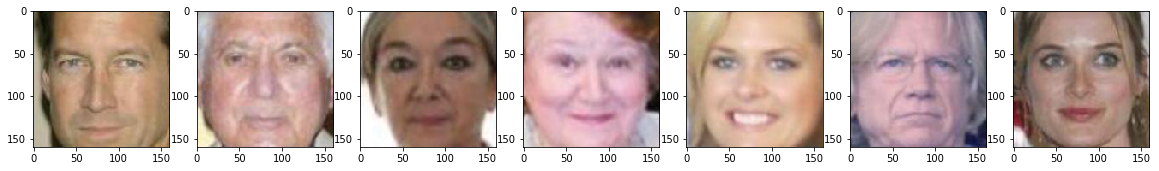

original


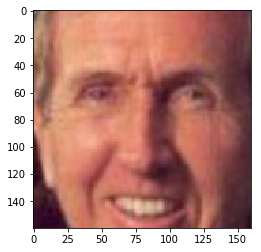

neighbour 32161
neighbour 122627
neighbour 59577
neighbour 103559
neighbour 195873
neighbour 62382
neighbour 179033


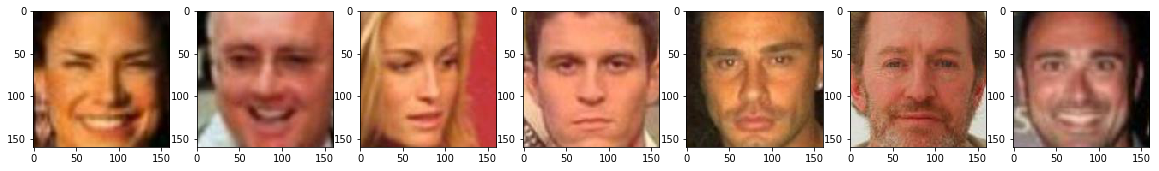

original


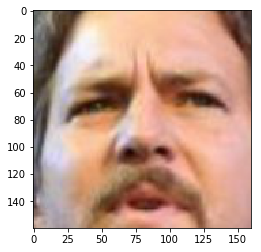

neighbour 185326
neighbour 39082
neighbour 22483
neighbour 126733
neighbour 147888
neighbour 39270
neighbour 109598


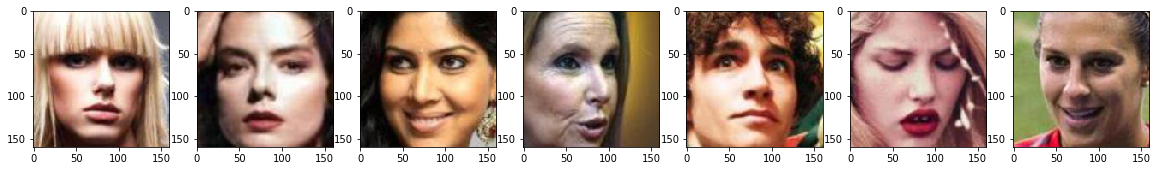

original


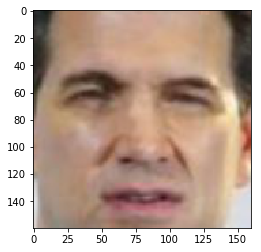

neighbour 194500
neighbour 199274
neighbour 195503
neighbour 2896
neighbour 197354
neighbour 34350
neighbour 47842


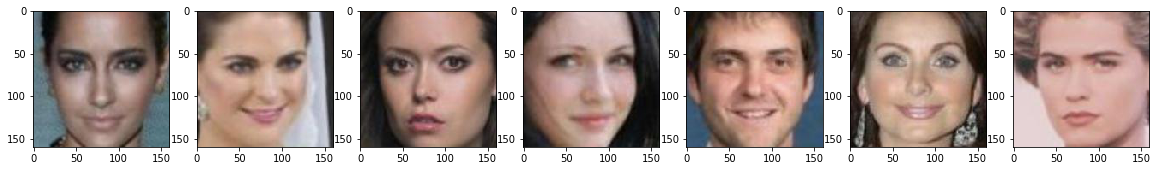

In [38]:
for j in range(len(btch.indices)):
    print('original')
    pic = btch.images[j]
    plt.imshow(pic)
    plt.show()
    fig, ax = plt.subplots(nrows=1, ncols=7, figsize=(20, 120))
    for i, neighbour_index in enumerate(btch.neighbours[j][:7]):
        file_name = data.loc[neighbour_index, 'file_name']
        print('neighbour', file_name)
        pic = imread('../img_align_celeba/cropped_photos/' + str(file_name) + '.jpg')
        ax[i].imshow(pic)
    plt.show()

original


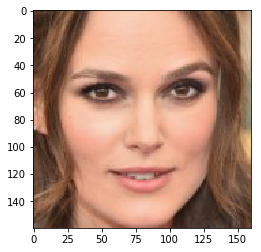

neighbour 101265
neighbour 106961
neighbour 109144
neighbour 105655
neighbour 109782
neighbour 101275
neighbour 109252


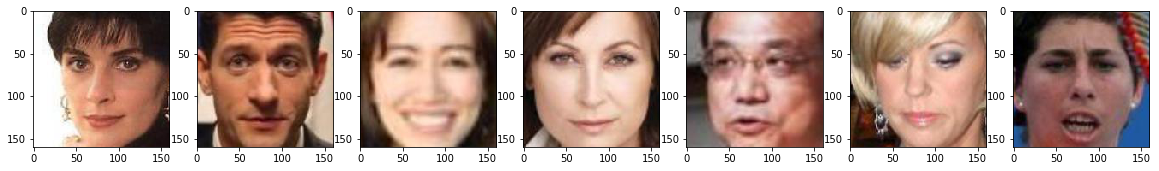

In [222]:
for j in range(len(btch.indices)):
    print('original')
    pic = btch.images[j]
    plt.imshow(pic)
    plt.show()
    fig, ax = plt.subplots(nrows=1, ncols=7, figsize=(20, 120))
    for i, neighbour_index in enumerate(btch.neighbours[j][:7]):
        file_name = data.loc[neighbour_index, 'file_name']
        print('neighbour', file_name)
        pic = imread('../img_align_celeba/cropped_photos/' + str(file_name) + '.jpg')
        ax[i].imshow(pic)
    plt.show()